# Is podium


## Dependencies


The dependencies used are as follows


In [1]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor

import sys

sys.path.append("..")

from utils.custom_cvs import VariableTimeSeriesSplit
from utils.visualization import model_test

import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import warnings

warnings.simplefilter("ignore")

## Initialization


The fifth objective attribute to be addressed will be if the driver is podium or not.


In [2]:
df = pd.read_csv("../assets/data/processed/base_model.csv")

instances_per_year = df["raceYear"].value_counts(sort=False)
instances_per_half = (
    np.array(
        list(zip(np.floor(instances_per_year / 2), np.ceil(instances_per_year / 2)))
    )
    .flatten()
    .astype(np.int32)
)

n_splits = len(instances_per_half) - 10
max_train_size = [instances_per_half[i : 10 + i].sum() for i in range(n_splits)]
test_size = instances_per_half[10:].tolist()
tscv = VariableTimeSeriesSplit(
    n_splits=n_splits, max_train_size=max_train_size, test_size=test_size
)

labels = np.array(["not_podium", "podium"])
podiums = df[df["positionFinal"].isin([1, 2, 3])][
    ["raceYear", "raceRound", "driverRef"]
]
podiums = podiums.groupby(by=["raceYear", "raceRound"]).agg({"driverRef": ",".join})

X = pd.read_csv("../assets/data/processed/base_model_X.csv")
y = df.merge(podiums, how="left", on=["raceYear", "raceRound"], suffixes=("", "Podium"))
y = y.apply(lambda x: x["driverRef"] in x["driverRefPodium"], axis=1)

## K-Nearest Neighbors


KNeighborsClassifier(metric='cosine', n_jobs=-1):
CV with make_scorer(balanced_accuracy_score): 0.7178911666434671
CV with neg_mean_absolute_error: nan
              precision    recall  f1-score   support

  not_podium       0.92      0.95      0.93      4545
      podium       0.61      0.49      0.54       756

    accuracy                           0.88      5301
   macro avg       0.77      0.72      0.74      5301
weighted avg       0.87      0.88      0.88      5301

KNeighborsRegressor(metric='cosine', n_jobs=-1):
CV with make_scorer(balanced_accuracy_score): 0.7178911666434671
CV with neg_mean_absolute_error: -0.14493489558691863
              precision    recall  f1-score   support

  not_podium       0.92      0.95      0.93      4545
      podium       0.61      0.49      0.54       756

    accuracy                           0.88      5301
   macro avg       0.77      0.72      0.74      5301
weighted avg       0.87      0.88      0.88      5301



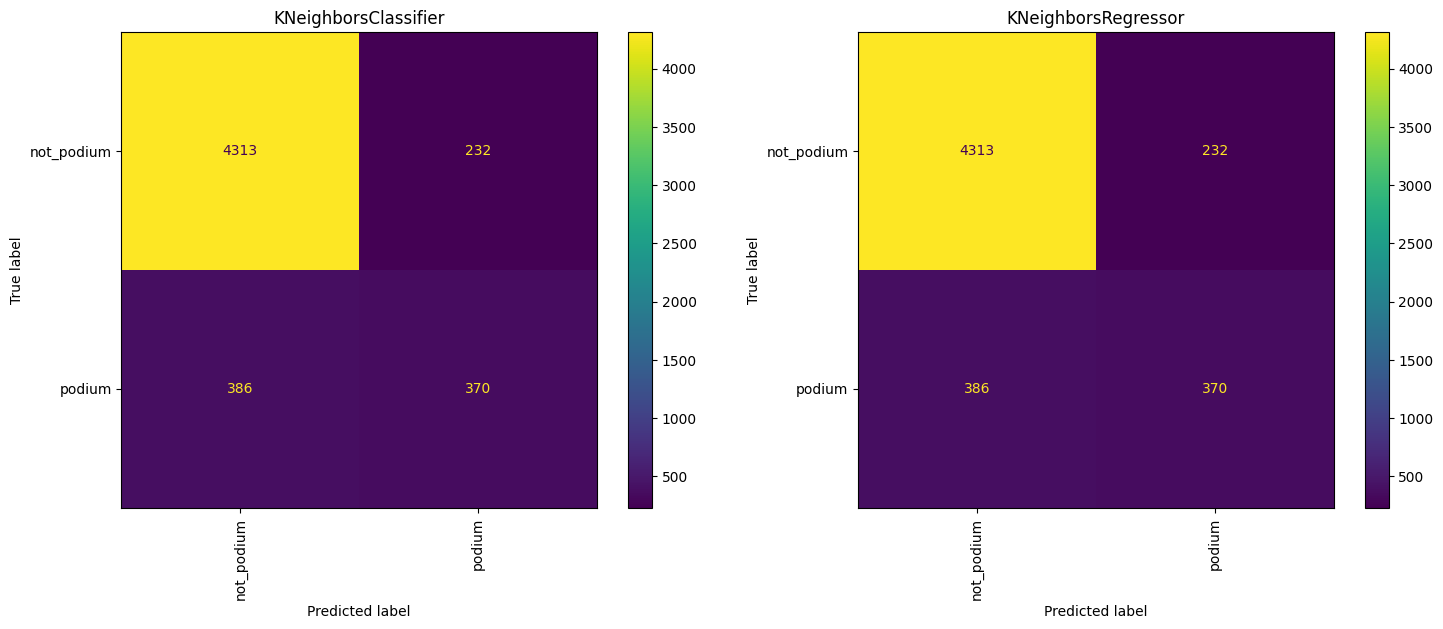

In [3]:
knn = (
    KNeighborsClassifier(n_neighbors=5, metric="cosine", n_jobs=-1),
    KNeighborsRegressor(n_neighbors=5, metric="cosine", n_jobs=-1),
)
model_test(knn, X, y, tscv, labels=labels)

## Decision Tree


DecisionTreeClassifier(max_depth=2):
CV with make_scorer(balanced_accuracy_score): 0.776910425510872
CV with neg_mean_absolute_error: nan
              precision    recall  f1-score   support

  not_podium       0.93      0.96      0.95      4545
      podium       0.70      0.59      0.64       756

    accuracy                           0.91      5301
   macro avg       0.82      0.78      0.79      5301
weighted avg       0.90      0.91      0.90      5301

DecisionTreeRegressor(criterion='absolute_error', max_depth=2):
CV with make_scorer(balanced_accuracy_score): 0.7760343733914392
CV with neg_mean_absolute_error: -0.09719665955947585
              precision    recall  f1-score   support

  not_podium       0.93      0.95      0.94      4545
      podium       0.68      0.60      0.64       756

    accuracy                           0.90      5301
   macro avg       0.81      0.78      0.79      5301
weighted avg       0.90      0.90      0.90      5301



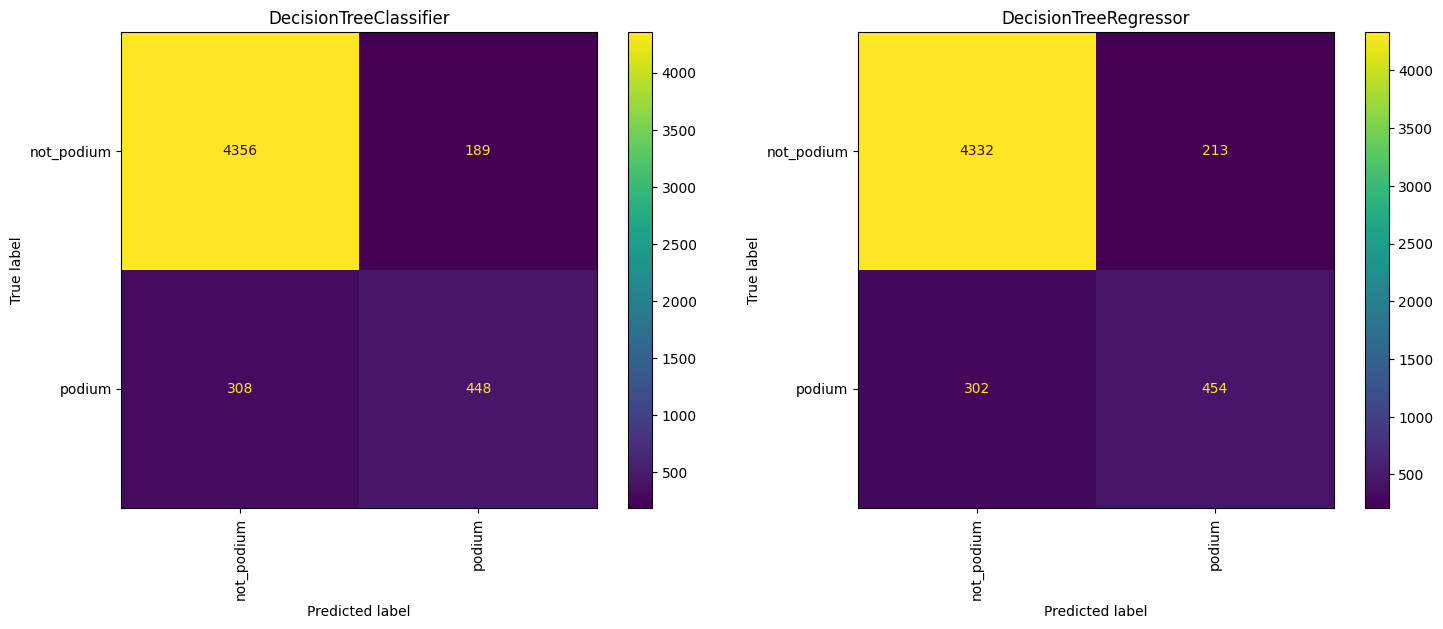

In [4]:
tree = (
    DecisionTreeClassifier(max_depth=2, criterion="gini"),
    DecisionTreeRegressor(max_depth=2, criterion="absolute_error"),
)
model_test(tree, X, y, tscv, labels=labels)

## Random Forest


RandomForestClassifier(max_depth=5, n_estimators=7, n_jobs=-1):
CV with make_scorer(balanced_accuracy_score): 0.7461590608964905
CV with neg_mean_absolute_error: nan
              precision    recall  f1-score   support

  not_podium       0.92      0.97      0.94      4545
      podium       0.72      0.51      0.60       756

    accuracy                           0.90      5301
   macro avg       0.82      0.74      0.77      5301
weighted avg       0.89      0.90      0.90      5301

RandomForestRegressor(criterion='absolute_error', max_depth=5, n_estimators=7,
                      n_jobs=-1):
CV with make_scorer(balanced_accuracy_score): 0.7638898009079662
CV with neg_mean_absolute_error: -0.10504449198584385
              precision    recall  f1-score   support

  not_podium       0.93      0.96      0.94      4545
      podium       0.69      0.59      0.63       756

    accuracy                           0.90      5301
   macro avg       0.81      0.77      0.79      5301
wei

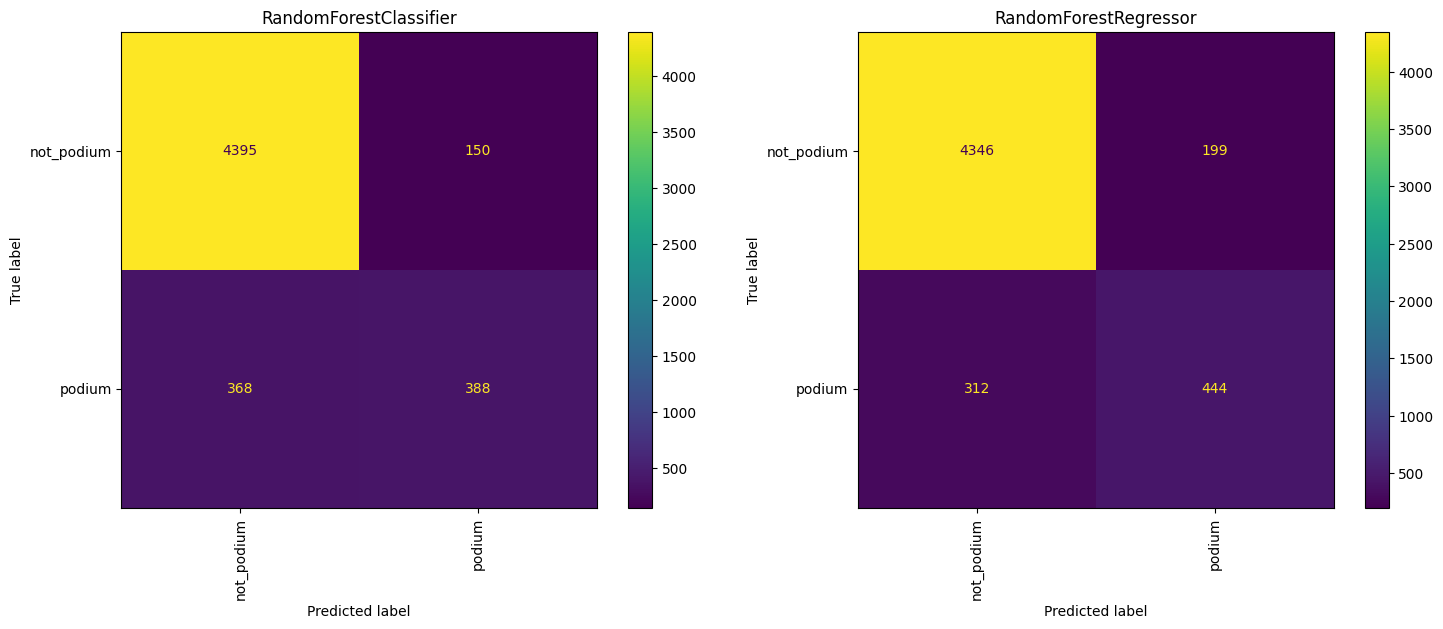

In [5]:
random_forest = (
    RandomForestClassifier(n_estimators=7, max_depth=5, criterion="gini", n_jobs=-1),
    RandomForestRegressor(
        n_estimators=7, max_depth=5, criterion="absolute_error", n_jobs=-1
    ),
)
model_test(random_forest, X, y, tscv, labels=labels)

## Multilayer Perceptron


MLPClassifier(activation='logistic', hidden_layer_sizes=(50, 25)):
CV with make_scorer(balanced_accuracy_score): 0.789960489573551
CV with neg_mean_absolute_error: nan
              precision    recall  f1-score   support

  not_podium       0.94      0.95      0.95      4545
      podium       0.70      0.64      0.67       756

    accuracy                           0.91      5301
   macro avg       0.82      0.80      0.81      5301
weighted avg       0.91      0.91      0.91      5301

MLPRegressor(activation='logistic', hidden_layer_sizes=(60, 30)):
CV with make_scorer(balanced_accuracy_score): 0.7058714933238645
CV with neg_mean_absolute_error: -0.17724826763496934
              precision    recall  f1-score   support

  not_podium       0.91      0.97      0.94      4545
      podium       0.73      0.44      0.55       756

    accuracy                           0.90      5301
   macro avg       0.82      0.71      0.75      5301
weighted avg       0.89      0.90      0.89     

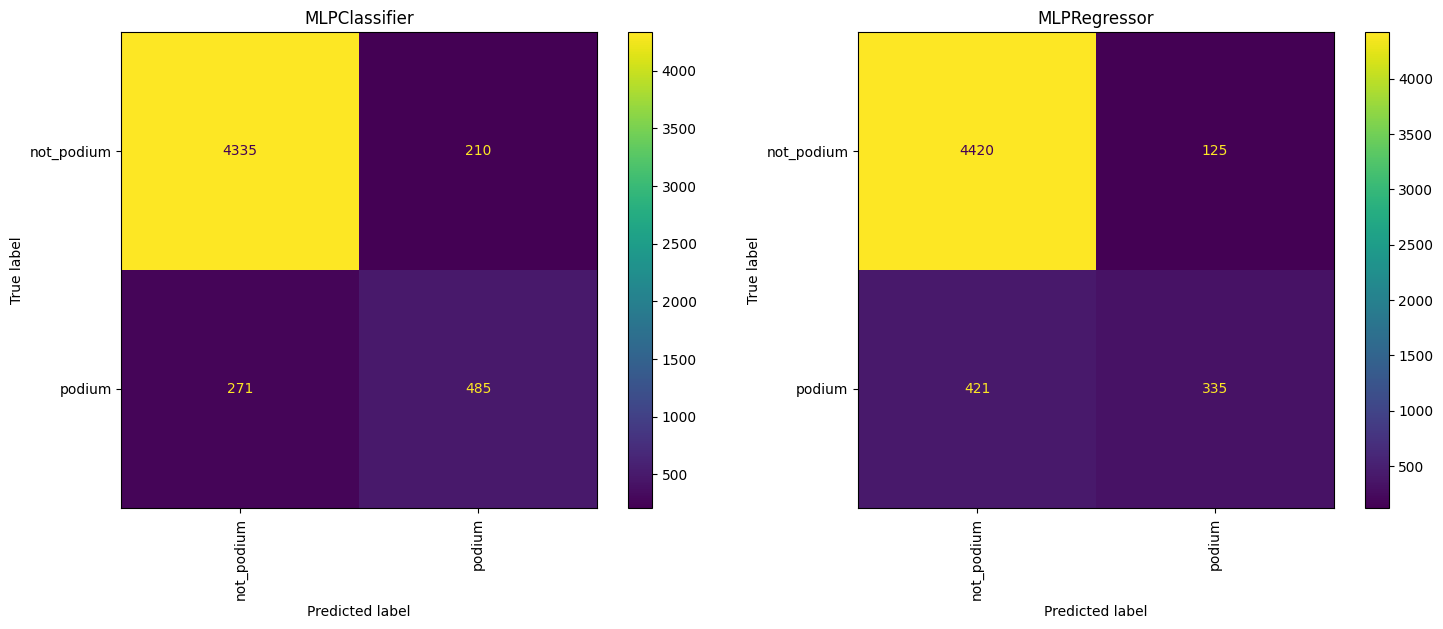

In [6]:
nn = (
    MLPClassifier(hidden_layer_sizes=(50, 25), activation="logistic"),
    MLPRegressor(hidden_layer_sizes=(60, 30), activation="logistic"),
)
model_test(nn, X, y, tscv, labels=labels)